# Advanced Feature Selection for HAI-21.03 Dataset (Fixed Version)

This notebook implements advanced feature selection techniques for the HAI-21.03 industrial control system security dataset with corrected file paths and directory handling.

In [11]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE, RFECV
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mutual_info_score
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('ggplot')
sns.set(style="darkgrid")

# Set random seeds for reproducibility
np.random.seed(42)

## 1. Global Variables Setup

In [12]:
# Set paths - FIXED PATHS to match the directory structure
OUTPUT_DIR = '../hai-security-dataset/processed'
FEATURE_DIR = '../hai-security-dataset/features'

# Create directories if they don't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(FEATURE_DIR, exist_ok=True)

# Print current working directory to verify path
print(f"Current working directory: {os.getcwd()}")
print(f"Output directory: {os.path.abspath(OUTPUT_DIR)}")
print(f"Feature directory: {os.path.abspath(FEATURE_DIR)}")

# List files in directories
print("\nFiles in output directory:")
if os.path.exists(OUTPUT_DIR):
    files = os.listdir(OUTPUT_DIR)
    for file in files:
        print(f"  {file}")
else:
    print(f"  Directory {OUTPUT_DIR} does not exist")

print("\nFiles in feature directory:")
if os.path.exists(FEATURE_DIR):
    files = os.listdir(FEATURE_DIR)
    if files:
        for file in files:
            print(f"  {file}")
    else:
        print("  No files found (directory is empty)")
else:
    print(f"  Directory {FEATURE_DIR} does not exist")

Current working directory: c:\Users\User\WebstormProjects\hai-dataset-analysis\exp2
Output directory: c:\Users\User\WebstormProjects\hai-dataset-analysis\hai-security-dataset\processed
Feature directory: c:\Users\User\WebstormProjects\hai-dataset-analysis\hai-security-dataset\features

Files in output directory:
  enhanced_graph_v2.pkl
  feature_info.pkl
  merged_train.csv
  pca.pkl
  scaler.pkl
  test1.parquet
  test1_processed.csv
  test1_processed_enhanced_v2.csv
  test2.parquet
  test2_processed.csv
  test3.parquet
  test3_processed.csv
  test4.parquet
  test4_processed.csv
  test5.parquet
  test5_processed.csv
  train1.parquet
  train1_processed_enhanced_v2.csv
  train2.parquet
  train3.parquet
  train_processed.csv

Files in feature directory:
  No files found (directory is empty)


## 2. Load Enhanced Data

In [13]:
# Check if the processed files exist
def check_file_exists(file_path):
    exists = os.path.exists(file_path)
    if exists:
        size_mb = os.path.getsize(file_path)/1024/1024
        print(f"Checking {file_path}: Exists ({size_mb:.2f} MB)")
    else:
        print(f"Checking {file_path}: Not found")
    return exists

# Look for processed files
train_files = [f for f in os.listdir(OUTPUT_DIR) if f.startswith('train') and f.endswith('_processed_enhanced_v2.csv')]
if not train_files:
    train_files = [f for f in os.listdir(OUTPUT_DIR) if f.startswith('train') and f.endswith('_processed.csv')]

test_files = [f for f in os.listdir(OUTPUT_DIR) if f.startswith('test') and f.endswith('_processed_enhanced_v2.csv')]
if not test_files:
    test_files = [f for f in os.listdir(OUTPUT_DIR) if f.startswith('test') and f.endswith('_processed.csv')]

print(f"Found {len(train_files)} train files and {len(test_files)} test files")

# Check the first train and test file
if train_files:
    train_file_path = os.path.join(OUTPUT_DIR, train_files[0])
    check_file_exists(train_file_path)
if test_files:
    test_file_path = os.path.join(OUTPUT_DIR, test_files[0])
    check_file_exists(test_file_path)

Found 1 train files and 1 test files
Checking ../hai-security-dataset/processed\train1_processed_enhanced_v2.csv: Exists (1846.24 MB)
Checking ../hai-security-dataset/processed\test1_processed_enhanced_v2.csv: Exists (367.73 MB)


In [14]:
# Load the first train file
if train_files:
    print(f"Loading {train_files[0]}...")
    train_df = pd.read_csv(os.path.join(OUTPUT_DIR, train_files[0]))
    print(f"Loaded {train_files[0]}: {train_df.shape[0]} rows, {train_df.shape[1]} columns")
else:
    raise FileNotFoundError("No processed training data found. Please run the feature engineering notebook first.")

Loading train1_processed_enhanced_v2.csv...
Loaded train1_processed_enhanced_v2.csv: 216001 rows, 822 columns


In [15]:
# Load test data
test_data = {}
if test_files:
    print(f"Loading test files...")
    for file in test_files[:1]:  # Load only the first test file to save memory
        file_path = os.path.join(OUTPUT_DIR, file)
        file_name = file.split('_')[0]  # Extract test file name (e.g., 'test1')
        df = pd.read_csv(file_path)
        test_data[file_name] = df
        print(f"Loaded {file_name}: {df.shape[0]} rows, {df.shape[1]} columns")
else:
    print("No processed test data found. Will only work with training data.")

Loading test files...
Loaded test1: 43201 rows, 788 columns


## 3. Feature Filtering

In [16]:
def filter_features(df):
    """
    Filter out non-feature columns and handle problematic features.
    
    Args:
        df (pd.DataFrame): Input dataframe
        
    Returns:
        tuple: (filtered_df, feature_cols, target_col)
    """
    # Exclude non-numeric columns
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    
    # Exclude time and attack columns from features
    exclude_cols = [col for col in df.columns if col.startswith('time')]
    target_col = 'attack'
    
    # Get feature columns
    feature_cols = [col for col in numeric_cols if col not in exclude_cols and col != target_col]
    
    # Check for constant or near-constant features
    variance = df[feature_cols].var()
    constant_features = variance[variance < 1e-10].index.tolist()
    if constant_features:
        print(f"Removing {len(constant_features)} constant or near-constant features")
        feature_cols = [col for col in feature_cols if col not in constant_features]
    
    # Check for features with too many NaN values
    nan_percentage = df[feature_cols].isna().mean()
    high_nan_features = nan_percentage[nan_percentage > 0.1].index.tolist()
    if high_nan_features:
        print(f"Removing {len(high_nan_features)} features with >10% NaN values")
        feature_cols = [col for col in feature_cols if col not in high_nan_features]
    
    # Check for features with infinite values
    inf_features = []
    for col in feature_cols:
        if np.isinf(df[col]).any():
            inf_features.append(col)
    
    if inf_features:
        print(f"Removing {len(inf_features)} features with infinite values")
        feature_cols = [col for col in feature_cols if col not in inf_features]
    
    print(f"Selected {len(feature_cols)} valid features out of {len(numeric_cols)} numeric columns")
    
    return df[feature_cols + [target_col]], feature_cols, target_col

In [17]:
# Filter features
filtered_train_df, feature_cols, target_col = filter_features(train_df)

# Extract features and target
X_train = filtered_train_df[feature_cols].values
y_train = filtered_train_df[target_col].values

print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")

Removing 53 constant or near-constant features
Removing 143 features with >10% NaN values
Selected 624 valid features out of 821 numeric columns
Training data shape: X=(216001, 624), y=(216001,)


## 4. Feature Scaling

In [18]:
def compare_scalers(X_train):
    """
    Compare different scaling methods.
    
    Args:
        X_train (np.array): Training data
        
    Returns:
        dict: Dictionary of scaled data and scalers
    """
    # Define scalers to compare
    scalers = {
        'StandardScaler': StandardScaler(),
        'RobustScaler': RobustScaler(),
        'MinMaxScaler': MinMaxScaler(),
        'QuantileTransformer': QuantileTransformer(output_distribution='normal')
    }
    
    # Apply each scaler
    scaled_data = {}
    for name, scaler in scalers.items():
        print(f"Applying {name}...")
        X_scaled = scaler.fit_transform(X_train)
        scaled_data[name] = {'data': X_scaled, 'scaler': scaler}
    
    return scaled_data

Applying StandardScaler...
Applying RobustScaler...
Applying MinMaxScaler...
Applying QuantileTransformer...


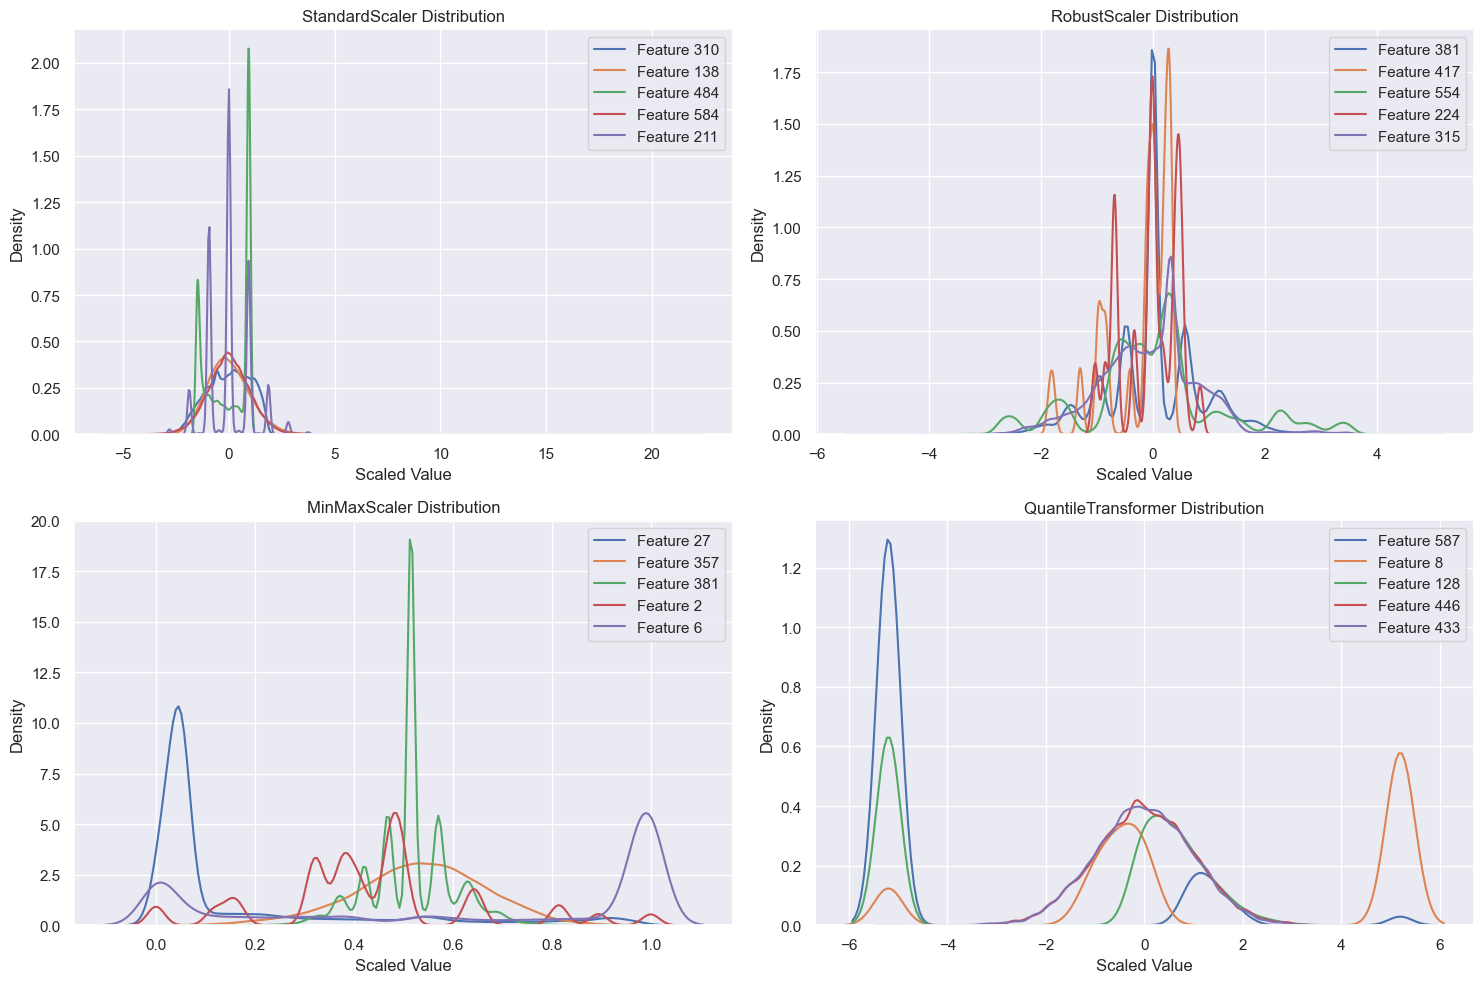

In [19]:
# Compare different scaling methods
scaled_data = compare_scalers(X_train)

# Visualize scaled data distributions
plt.figure(figsize=(15, 10))
for i, (name, data_dict) in enumerate(scaled_data.items()):
    plt.subplot(2, 2, i+1)
    
    # Sample a few features for visualization
    sample_features = np.random.choice(data_dict['data'].shape[1], min(5, data_dict['data'].shape[1]), replace=False)
    
    for j in sample_features:
        sns.kdeplot(data_dict['data'][:, j], label=f'Feature {j}')
    
    plt.title(f'{name} Distribution')
    plt.xlabel('Scaled Value')
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()

In [20]:
# Select the best scaler (RobustScaler is often good for anomaly detection)
selected_scaler_name = 'RobustScaler'
X_train_scaled = scaled_data[selected_scaler_name]['data']
scaler = scaled_data[selected_scaler_name]['scaler']

print(f"Selected {selected_scaler_name} for feature scaling")

# Save the scaler
with open(os.path.join(FEATURE_DIR, 'feature_scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)
print(f"Saved scaler to {os.path.join(FEATURE_DIR, 'feature_scaler.pkl')}")

Selected RobustScaler for feature scaling
Saved scaler to ../hai-security-dataset/features\feature_scaler.pkl


## 5. Filter-Based Feature Selection

In [21]:
def apply_filter_methods(X_train_scaled, y_train, feature_cols, k=50):
    """
    Apply filter-based feature selection methods.
    
    Args:
        X_train_scaled (np.array): Scaled training data
        y_train (np.array): Target values
        feature_cols (list): Feature column names
        k (int): Number of features to select
        
    Returns:
        dict: Dictionary of selected features for each method
    """
    results = {}
    
    # 1. Variance Threshold
    print("Applying Variance Threshold...")
    selector = VarianceThreshold(threshold=0.01)
    X_var = selector.fit_transform(X_train_scaled)
    var_support = selector.get_support()
    var_features = [feature_cols[i] for i in range(len(feature_cols)) if var_support[i]]
    results['variance_threshold'] = {
        'support': var_support,
        'features': var_features,
        'scores': selector.variances_,
        'data': X_var
    }
    print(f"  Selected {len(var_features)} features")
    
    # 2. ANOVA F-value
    print("Applying ANOVA F-value...")
    selector = SelectKBest(f_classif, k=min(k, X_train_scaled.shape[1]))
    X_anova = selector.fit_transform(X_train_scaled, y_train)
    anova_support = selector.get_support()
    anova_features = [feature_cols[i] for i in range(len(feature_cols)) if anova_support[i]]
    results['anova'] = {
        'support': anova_support,
        'features': anova_features,
        'scores': selector.scores_,
        'data': X_anova
    }
    print(f"  Selected {len(anova_features)} features")
    
    # 3. Mutual Information
    print("Applying Mutual Information...")
    selector = SelectKBest(mutual_info_classif, k=min(k, X_train_scaled.shape[1]))
    X_mi = selector.fit_transform(X_train_scaled, y_train)
    mi_support = selector.get_support()
    mi_features = [feature_cols[i] for i in range(len(feature_cols)) if mi_support[i]]
    results['mutual_info'] = {
        'support': mi_support,
        'features': mi_features,
        'scores': selector.scores_,
        'data': X_mi
    }
    print(f"  Selected {len(mi_features)} features")
    
    return results

In [ ]:
# Apply filter-based methods
filter_results = apply_filter_methods(X_train_scaled, y_train, feature_cols, k=50)

# Save filter results
with open(os.path.join(FEATURE_DIR, 'filter_results.pkl'), 'wb') as f:
    pickle.dump(filter_results, f)
print(f"Saved filter results to {os.path.join(FEATURE_DIR, 'filter_results.pkl')}")

# Visualize feature importance for each method
plt.figure(figsize=(15, 15))

# 1. Variance Threshold
plt.subplot(3, 1, 1)
var_scores = filter_results['variance_threshold']['scores']
var_features = feature_cols
sorted_idx = np.argsort(var_scores)[::-1]
plt.bar(range(min(20, len(var_features))), var_scores[sorted_idx[:20]])
plt.xticks(range(min(20, len(var_features))), [var_features[i] for i in sorted_idx[:20]], rotation=90)
plt.title('Top 20 Features by Variance')
plt.xlabel('Features')
plt.ylabel('Variance')

# 2. ANOVA F-value
plt.subplot(3, 1, 2)
anova_scores = filter_results['anova']['scores']
anova_support = filter_results['anova']['support']
anova_features = [feature_cols[i] for i in range(len(feature_cols)) if anova_support[i]]
sorted_idx = np.argsort(anova_scores)[::-1]
plt.bar(range(min(20, len(anova_features))), [anova_scores[i] for i in sorted_idx[:20]])
plt.xticks(range(min(20, len(anova_features))), [feature_cols[i] for i in sorted_idx[:20]], rotation=90)
plt.title('Top 20 Features by ANOVA F-value')
plt.xlabel('Features')
plt.ylabel('F-value')

# 3. Mutual Information
plt.subplot(3, 1, 3)
mi_scores = filter_results['mutual_info']['scores']
mi_support = filter_results['mutual_info']['support']
mi_features = [feature_cols[i] for i in range(len(feature_cols)) if mi_support[i]]
sorted_idx = np.argsort(mi_scores)[::-1]
plt.bar(range(min(20, len(mi_features))), [mi_scores[i] for i in sorted_idx[:20]])
plt.xticks(range(min(20, len(mi_features))), [feature_cols[i] for i in sorted_idx[:20]], rotation=90)
plt.title('Top 20 Features by Mutual Information')
plt.xlabel('Features')
plt.ylabel('Mutual Information')

plt.tight_layout()
plt.show()

Applying Variance Threshold...
  Selected 620 features
Applying ANOVA F-value...


ValueError: Input X contains NaN.
SelectKBest does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

## 6. Wrapper-Based Feature Selection

In [ ]:
def apply_wrapper_methods(X_train_scaled, y_train, feature_cols):
    """
    Apply wrapper-based feature selection methods.
    
    Args:
        X_train_scaled (np.array): Scaled training data
        y_train (np.array): Target values
        feature_cols (list): Feature column names
        
    Returns:
        dict: Dictionary of selected features for each method
    """
    results = {}
    
    # 1. Recursive Feature Elimination (RFE)
    print("Applying Recursive Feature Elimination...")
    estimator = RandomForestClassifier(n_estimators=100, random_state=42)
    selector = RFE(estimator, n_features_to_select=min(50, X_train_scaled.shape[1]), step=0.1)
    X_rfe = selector.fit_transform(X_train_scaled, y_train)
    rfe_support = selector.get_support()
    rfe_features = [feature_cols[i] for i in range(len(feature_cols)) if rfe_support[i]]
    results['rfe'] = {
        'support': rfe_support,
        'features': rfe_features,
        'ranking': selector.ranking_,
        'data': X_rfe
    }
    print(f"  Selected {len(rfe_features)} features")
    
    # 2. Random Forest Feature Importance
    print("Applying Random Forest Feature Importance...")
    estimator = RandomForestClassifier(n_estimators=100, random_state=42)
    estimator.fit(X_train_scaled, y_train)
    rf_importances = estimator.feature_importances_
    rf_indices = np.argsort(rf_importances)[::-1]
    rf_features = [feature_cols[i] for i in rf_indices[:50]]
    results['random_forest'] = {
        'features': rf_features,
        'importances': rf_importances,
        'indices': rf_indices
    }
    print(f"  Selected {len(rf_features)} features")
    
    # 3. Gradient Boosting Feature Importance
    print("Applying Gradient Boosting Feature Importance...")
    estimator = GradientBoostingClassifier(n_estimators=100, random_state=42)
    estimator.fit(X_train_scaled, y_train)
    gb_importances = estimator.feature_importances_
    gb_indices = np.argsort(gb_importances)[::-1]
    gb_features = [feature_cols[i] for i in gb_indices[:50]]
    results['gradient_boosting'] = {
        'features': gb_features,
        'importances': gb_importances,
        'indices': gb_indices
    }
    print(f"  Selected {len(gb_features)} features")
    
    return results

In [ ]:
# Apply wrapper-based methods
wrapper_results = apply_wrapper_methods(X_train_scaled, y_train, feature_cols)

# Save wrapper results
with open(os.path.join(FEATURE_DIR, 'wrapper_results.pkl'), 'wb') as f:
    pickle.dump(wrapper_results, f)
print(f"Saved wrapper results to {os.path.join(FEATURE_DIR, 'wrapper_results.pkl')}")

# Visualize feature importance for each method
plt.figure(figsize=(15, 15))

# 1. RFE
plt.subplot(3, 1, 1)
rfe_ranking = wrapper_results['rfe']['ranking']
sorted_idx = np.argsort(rfe_ranking)
plt.bar(range(20), [rfe_ranking[i] for i in sorted_idx[:20]])
plt.xticks(range(20), [feature_cols[i] for i in sorted_idx[:20]], rotation=90)
plt.title('Top 20 Features by RFE (lower rank is better)')
plt.xlabel('Features')
plt.ylabel('Ranking')

# 2. Random Forest
plt.subplot(3, 1, 2)
rf_importances = wrapper_results['random_forest']['importances']
rf_indices = wrapper_results['random_forest']['indices']
plt.bar(range(20), rf_importances[rf_indices[:20]])
plt.xticks(range(20), [feature_cols[i] for i in rf_indices[:20]], rotation=90)
plt.title('Top 20 Features by Random Forest Importance')
plt.xlabel('Features')
plt.ylabel('Importance')

# 3. Gradient Boosting
plt.subplot(3, 1, 3)
gb_importances = wrapper_results['gradient_boosting']['importances']
gb_indices = wrapper_results['gradient_boosting']['indices']
plt.bar(range(20), gb_importances[gb_indices[:20]])
plt.xticks(range(20), [feature_cols[i] for i in gb_indices[:20]], rotation=90)
plt.title('Top 20 Features by Gradient Boosting Importance')
plt.xlabel('Features')
plt.ylabel('Importance')

plt.tight_layout()
plt.show()

## 7. Embedded-Based Feature Selection

In [ ]:
def apply_embedded_methods(X_train_scaled, y_train, feature_cols):
    """
    Apply embedded feature selection methods.
    
    Args:
        X_train_scaled (np.array): Scaled training data
        y_train (np.array): Target values
        feature_cols (list): Feature column names
        
    Returns:
        dict: Dictionary of selected features for each method
    """
    results = {}
    
    # 1. Lasso
    print("Applying Lasso...")
    lasso = Lasso(alpha=0.01)
    lasso.fit(X_train_scaled, y_train)
    lasso_coef = np.abs(lasso.coef_)
    lasso_indices = np.argsort(lasso_coef)[::-1]
    lasso_features = [feature_cols[i] for i in lasso_indices[:50]]
    results['lasso'] = {
        'features': lasso_features,
        'coefficients': lasso_coef,
        'indices': lasso_indices
    }
    print(f"  Selected {len(lasso_features)} features")
    
    # 2. SelectFromModel with Random Forest
    print("Applying SelectFromModel with Random Forest...")
    estimator = RandomForestClassifier(n_estimators=100, random_state=42)
    selector = SelectFromModel(estimator, threshold='median')
    X_sfm = selector.fit_transform(X_train_scaled, y_train)
    sfm_support = selector.get_support()
    sfm_features = [feature_cols[i] for i in range(len(feature_cols)) if sfm_support[i]]
    results['select_from_model'] = {
        'support': sfm_support,
        'features': sfm_features,
        'data': X_sfm
    }
    print(f"  Selected {len(sfm_features)} features")
    
    return results

In [ ]:
# Apply embedded-based methods
embedded_results = apply_embedded_methods(X_train_scaled, y_train, feature_cols)

# Save embedded results
with open(os.path.join(FEATURE_DIR, 'embedded_results.pkl'), 'wb') as f:
    pickle.dump(embedded_results, f)
print(f"Saved embedded results to {os.path.join(FEATURE_DIR, 'embedded_results.pkl')}")

# Visualize feature importance for each method
plt.figure(figsize=(15, 10))

# 1. Lasso
plt.subplot(2, 1, 1)
lasso_coef = embedded_results['lasso']['coefficients']
lasso_indices = embedded_results['lasso']['indices']
plt.bar(range(20), lasso_coef[lasso_indices[:20]])
plt.xticks(range(20), [feature_cols[i] for i in lasso_indices[:20]], rotation=90)
plt.title('Top 20 Features by Lasso Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient')

# 2. SelectFromModel
plt.subplot(2, 1, 2)
sfm_support = embedded_results['select_from_model']['support']
sfm_features = embedded_results['select_from_model']['features']
plt.bar(range(len(sfm_features)), [1] * len(sfm_features))
plt.xticks(range(len(sfm_features)), sfm_features, rotation=90)
plt.title('Features Selected by SelectFromModel')
plt.xlabel('Features')
plt.ylabel('Selected')

plt.tight_layout()
plt.show()

## 8. Feature Ranking and Ensemble Selection

In [ ]:
def ensemble_feature_selection(filter_results, wrapper_results, embedded_results, feature_cols):
    """
    Combine results from different feature selection methods.
    
    Args:
        filter_results (dict): Results from filter-based methods
        wrapper_results (dict): Results from wrapper-based methods
        embedded_results (dict): Results from embedded-based methods
        feature_cols (list): Feature column names
        
    Returns:
        tuple: (ensemble_features, feature_scores)
    """
    # Initialize feature scores
    feature_scores = {feature: 0 for feature in feature_cols}
    
    # Collect all selected features
    all_selected_features = []
    
    # Add filter-based features
    all_selected_features.extend(filter_results['anova']['features'])
    all_selected_features.extend(filter_results['mutual_info']['features'])
    
    # Add wrapper-based features
    all_selected_features.extend(wrapper_results['rfe']['features'])
    all_selected_features.extend(wrapper_results['random_forest']['features'])
    all_selected_features.extend(wrapper_results['gradient_boosting']['features'])
    
    # Add embedded-based features
    all_selected_features.extend(embedded_results['lasso']['features'])
    all_selected_features.extend(embedded_results['select_from_model']['features'])
    
    # Count occurrences of each feature
    for feature in all_selected_features:
        feature_scores[feature] += 1
    
    # Sort features by score
    sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Select top features
    top_n = 50
    ensemble_features = [feature for feature, score in sorted_features[:top_n]]
    
    return ensemble_features, feature_scores

In [ ]:
# Apply ensemble feature selection
ensemble_features, feature_scores = ensemble_feature_selection(
    filter_results, wrapper_results, embedded_results, feature_cols
)

print(f"Selected {len(ensemble_features)} features using ensemble method")

# Save ensemble features
with open(os.path.join(FEATURE_DIR, 'ensemble_features.pkl'), 'wb') as f:
    pickle.dump({
        'ensemble_features': ensemble_features,
        'feature_scores': feature_scores
    }, f)
print(f"Saved ensemble features to {os.path.join(FEATURE_DIR, 'ensemble_features.pkl')}")

# Save feature names to text file
with open(os.path.join(FEATURE_DIR, 'selected_features.txt'), 'w') as f:
    for feature in ensemble_features:
        f.write(f"{feature}\n")
print(f"Saved selected feature names to {os.path.join(FEATURE_DIR, 'selected_features.txt')}")

# Visualize top features
plt.figure(figsize=(15, 8))
sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)[:30]
plt.bar([f[0] for f in sorted_features], [f[1] for f in sorted_features])
plt.xticks(rotation=90)
plt.title('Top 30 Features by Ensemble Selection')
plt.xlabel('Features')
plt.ylabel('Score (number of methods that selected the feature)')
plt.tight_layout()
plt.show()

## 9. Dimensionality Reduction

In [ ]:
def apply_dimensionality_reduction(X_train_scaled, ensemble_features, feature_cols):
    """
    Apply dimensionality reduction techniques.
    
    Args:
        X_train_scaled (np.array): Scaled training data
        ensemble_features (list): Selected features from ensemble method
        feature_cols (list): Feature column names
        
    Returns:
        dict: Dictionary of reduced data and transformers
    """
    # Get indices of ensemble features
    ensemble_indices = [feature_cols.index(feature) for feature in ensemble_features]
    X_ensemble = X_train_scaled[:, ensemble_indices]
    
    results = {}
    
    # 1. PCA
    print("Applying PCA...")
    n_components = min(20, X_ensemble.shape[1])
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_ensemble)
    explained_variance = np.sum(pca.explained_variance_ratio_)
    results['pca'] = {
        'data': X_pca,
        'transformer': pca,
        'explained_variance': explained_variance
    }
    print(f"  Reduced to {n_components} components with {explained_variance:.4f} explained variance")
    
    # 2. Kernel PCA
    print("Applying Kernel PCA...")
    kpca = KernelPCA(n_components=n_components, kernel='rbf')
    X_kpca = kpca.fit_transform(X_ensemble)
    results['kpca'] = {
        'data': X_kpca,
        'transformer': kpca
    }
    print(f"  Reduced to {n_components} components")
    
    # 3. FastICA
    print("Applying FastICA...")
    ica = FastICA(n_components=n_components, random_state=42)
    X_ica = ica.fit_transform(X_ensemble)
    results['ica'] = {
        'data': X_ica,
        'transformer': ica
    }
    print(f"  Reduced to {n_components} components")
    
    return results, ensemble_indices

In [ ]:
# Apply dimensionality reduction
reduction_results, ensemble_indices = apply_dimensionality_reduction(
    X_train_scaled, ensemble_features, feature_cols
)

# Save dimensionality reduction results
with open(os.path.join(FEATURE_DIR, 'reduction_results.pkl'), 'wb') as f:
    pickle.dump({
        'pca': reduction_results['pca']['transformer'],
        'kpca': reduction_results['kpca']['transformer'],
        'ica': reduction_results['ica']['transformer'],
        'ensemble_indices': ensemble_indices
    }, f)
print(f"Saved dimensionality reduction results to {os.path.join(FEATURE_DIR, 'reduction_results.pkl')}")

# Visualize PCA components
plt.figure(figsize=(10, 6))
pca = reduction_results['pca']['transformer']
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

In [ ]:
# Visualize first two components of each method
plt.figure(figsize=(15, 5))

# 1. PCA
plt.subplot(1, 3, 1)
X_pca = reduction_results['pca']['data']
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis', alpha=0.5)
plt.title('PCA')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Attack')

# 2. Kernel PCA
plt.subplot(1, 3, 2)
X_kpca = reduction_results['kpca']['data']
plt.scatter(X_kpca[:, 0], X_kpca[:, 1], c=y_train, cmap='viridis', alpha=0.5)
plt.title('Kernel PCA')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Attack')

# 3. FastICA
plt.subplot(1, 3, 3)
X_ica = reduction_results['ica']['data']
plt.scatter(X_ica[:, 0], X_ica[:, 1], c=y_train, cmap='viridis', alpha=0.5)
plt.title('FastICA')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Attack')

plt.tight_layout()
plt.show()

## 10. Save Feature Selection Results

In [ ]:
# Create a comprehensive feature selection results dictionary
feature_selection_results = {
    'ensemble_features': ensemble_features,
    'feature_scores': feature_scores,
    'ensemble_indices': ensemble_indices,
    'scaler': scaler,
    'pca': reduction_results['pca']['transformer'],
    'kpca': reduction_results['kpca']['transformer'],
    'ica': reduction_results['ica']['transformer']
}

# Save comprehensive results
with open(os.path.join(FEATURE_DIR, 'feature_selection_results.pkl'), 'wb') as f:
    pickle.dump(feature_selection_results, f)

print(f"Saved comprehensive feature selection results to {os.path.join(FEATURE_DIR, 'feature_selection_results.pkl')}")

# List all files in the feature directory to confirm they were created
print("\nFiles in feature directory:")
if os.path.exists(FEATURE_DIR):
    files = os.listdir(FEATURE_DIR)
    if files:
        for file in files:
            print(f"  {file}")
    else:
        print("  No files found (directory is empty)")
else:
    print(f"  Directory {FEATURE_DIR} does not exist")

In [ ]:
# Apply feature selection to test data
test_data_selected = {}

for name, df in test_data.items():
    print(f"Applying feature selection to {name}...")
    
    # Extract features and target
    X_test = df[feature_cols].values if all(col in df.columns for col in feature_cols) else None
    if X_test is None:
        print(f"  Warning: Not all feature columns found in {name}. Skipping.")
        continue
        
    y_test = df[target_col].values if target_col in df.columns else None
    
    # Scale features
    X_test_scaled = scaler.transform(X_test)
    
    # Select ensemble features
    X_test_ensemble = X_test_scaled[:, ensemble_indices]
    
    # Apply PCA
    X_test_pca = reduction_results['pca']['transformer'].transform(X_test_ensemble)
    
    test_data_selected[name] = {
        'X_scaled': X_test_scaled,
        'X_ensemble': X_test_ensemble,
        'X_pca': X_test_pca,
        'y': y_test
    }
    
    print(f"  Processed {name}: {X_test.shape} -> {X_test_ensemble.shape} -> {X_test_pca.shape}")

# Save processed test data
with open(os.path.join(FEATURE_DIR, 'test_data_selected.pkl'), 'wb') as f:
    pickle.dump(test_data_selected, f)

print(f"Saved selected test data to {os.path.join(FEATURE_DIR, 'test_data_selected.pkl')}")